In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import gurobi_logtools as glt

In [5]:
name = "Track_k_e_2_reruns"
PATH = f".\Experiments\{name}\Logs"

In [6]:
result = glt.parse(PATH+"\*.log")
summary = result.summary()


In [7]:

nl = result.progress("nodelog")
print(nl[~nl['Incumbent'].isna()])
nl.head()

      CurrentNode  RemainingNodes      Obj  Depth  IntInf  Incumbent  \
309         41072          2475.0      NaN    NaN     NaN   0.000979   
310         48503          2783.0      NaN   40.0     NaN   0.000980   
311         48825          2749.0      NaN    NaN     NaN   0.000925   
312         49687          2812.0      NaN    NaN     NaN   0.000925   
313         55406          3661.0  0.00084   54.0    44.0   0.000930   
...           ...             ...      ...    ...     ...        ...   
6657      1070354         80486.0      NaN    NaN     NaN   0.000214   
6658      1077338         80835.0  0.00021   77.0    44.0   0.000210   
6659      1091366         51955.0      NaN    NaN     NaN   0.000207   
6660      1091373         36764.0      NaN    NaN     NaN   0.000206   
6661      1091379             NaN      NaN    NaN     NaN   0.000206   

        BestBd       Gap  ItPerNode    Time  \
309   0.000210  0.790000       37.2   12.00   
310   0.000210  0.790000       37.3   15.

c:\Users\sian_\OneDrive\Documents\Thesis\MILP_Formulation\pyomo_env\lib\site-packages\gurobi_logtools\api.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  left=pd.concat(progress),


,CurrentNode,RemainingNodes,Obj,Depth,IntInf,Incumbent,BestBd,Gap,ItPerNode,Time,LogFilePath,LogNumber,Pruned,NewSolution,Seed,Version
0,0,0.0,0.00021,0.0,44.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
1,0,0.0,0.00021,0.0,74.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
2,0,0.0,0.00021,0.0,90.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
3,0,0.0,0.00021,0.0,93.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2
4,0,0.0,0.00021,0.0,91.0,NaN,0.00021,NaN,NaN,0.0,.\Experiments\Track_k_e_2_reruns\Logs\Track_k_...,1,NaN,NaN,0,11.0.2


In [44]:
regex_pattern = r'_r(\d+)_c(\d+)\.log'
nl[['Repetition', 'Config']] = nl['LogFilePath'].str.extract(regex_pattern)
nl['Repetition'] = nl['Repetition'].astype(int)
nl['Config'] = nl['Config'].astype(int)
nl.head()

nl = nl[nl['Repetition'] > 3]

In [45]:
grouped_nl = nl.groupby(['Config', 'Time']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl['Config'].unique()
grouped_nl.head()

Config  Time Incumbent       BestBd     
                    mean std     mean  std
0      1   0.0       NaN NaN  0.00021  0.0
1      1   5.0       NaN NaN  0.00021  0.0
2      1  10.0       NaN NaN  0.00021  0.0
3      1  12.0  0.000979 NaN  0.00021  NaN
4      1  13.0  0.000979 NaN  0.00021  NaN

In [46]:
grouped_nl.columns = ['Config', 'Time', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl.head()

,Config,Time,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0.0,NaN,NaN,0.00021,0.0
1,1,5.0,NaN,NaN,0.00021,0.0
2,1,10.0,NaN,NaN,0.00021,0.0
3,1,12.0,0.000979,NaN,0.00021,NaN
4,1,13.0,0.000979,NaN,0.00021,NaN


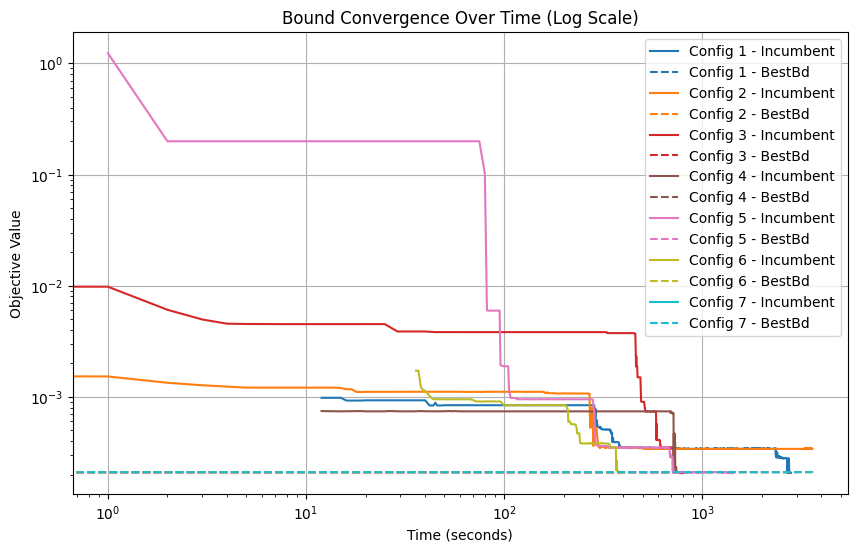

In [121]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10',len(grouped_nl['Config'].unique()))
print(colors)
for i, config in enumerate(configs):
    config_data = grouped_nl[grouped_nl['Config'] == config]
    color = colors(i)
    # Plot Incumbent
    plt.plot(config_data['Time'], config_data['Incumbent_mean'], label=f'Config {config} - Incumbent', color=color)
    #plt.fill_between(config_data['Time'], 
                    #  config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
                    #  config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
                    #  color='blue', alpha=0.2)

    # Plot BestBd
    plt.plot(config_data['Time'], config_data['BestBd_mean'], linestyle='--', label=f'Config {config} - BestBd', color=color)
    # plt.fill_between(config_data['Time'], 
    #                  config_data['BestBd_mean'] - config_data['BestBd_std'], 
    #                  config_data['BestBd_mean'] + config_data['BestBd_std'], 
    #                  color='orange', alpha=0.2)

# Set to log scale
plt.yscale('log')
plt.xscale('log')

# Add labels
plt.xlabel('Time (seconds)')
plt.ylabel('Objective Value')
plt.title('Bound Convergence Over Time')
plt.legend()
plt.grid(True)


plt.show()


In [48]:
grouped_nl2 = nl.groupby(['Config', 'CurrentNode']).agg({
    'Incumbent': ['mean', 'std'],
    'BestBd': ['mean', 'std']
}).reset_index()

configs = grouped_nl2['Config'].unique()
grouped_nl2.columns = ['Config', 'Node', 'Incumbent_mean', 'Incumbent_std', 'BestBd_mean', 'BestBd_std']
grouped_nl2.head()

,Config,Node,Incumbent_mean,Incumbent_std,BestBd_mean,BestBd_std
0,1,0,NaN,NaN,0.00021,0.0
1,1,13250,NaN,NaN,0.00021,NaN
2,1,15007,NaN,NaN,0.00021,NaN
3,1,27938,NaN,NaN,0.00021,NaN
4,1,32071,NaN,NaN,0.00021,NaN


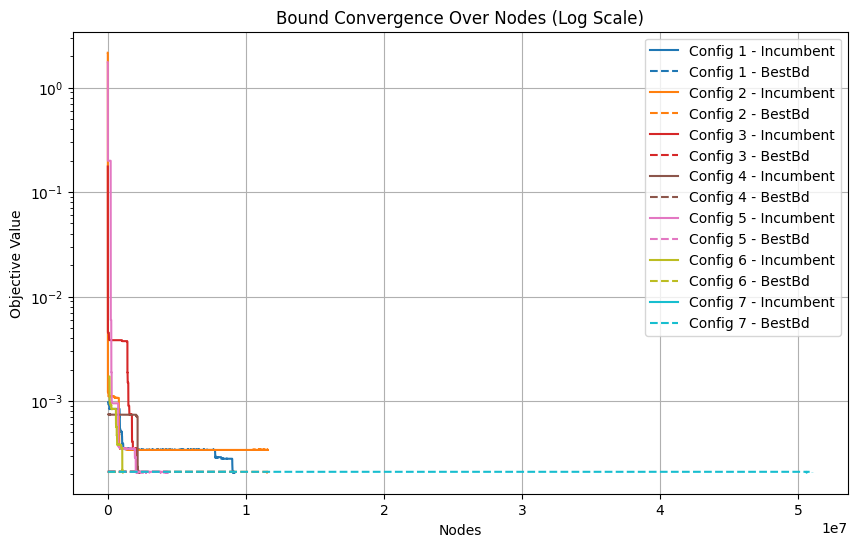

In [49]:
plt.figure(figsize=(10, 6))
colors = plt.get_cmap('tab10',len(grouped_nl['Config'].unique()))
print(colors)
for i, config in enumerate(configs):
    config_data = grouped_nl2[grouped_nl2['Config'] == config]
    color = colors(i)
    # Plot Incumbent
    plt.plot(config_data['Node'], config_data['Incumbent_mean'], label=f'Config {config} - Incumbent', color=color)
    #plt.fill_between(config_data['Time'], 
                    #  config_data['Incumbent_mean'] - config_data['Incumbent_std'], 
                    #  config_data['Incumbent_mean'] + config_data['Incumbent_std'], 
                    #  color='blue', alpha=0.2)

    # Plot BestBd
    plt.plot(config_data['Node'], config_data['BestBd_mean'], linestyle='--', label=f'Config {config} - BestBd', color=color)
    # plt.fill_between(config_data['Time'], 
    #                  config_data['BestBd_mean'] - config_data['BestBd_std'], 
    #                  config_data['BestBd_mean'] + config_data['BestBd_std'], 
    #                  color='orange', alpha=0.2)

# Set to log scale
plt.yscale('log')

# Add labels
plt.xlabel('Nodes')
plt.ylabel('Objective Value')
plt.title('Bound Convergence Over Nodes (Log Scale)')
plt.legend()
plt.grid(True)


plt.show()

In [112]:
import pandas as pd
path = '.\\Experiments\\Track_k_e_2_reruns'
df = pd.read_csv(path+"\summary_results.csv")
df

,Rep,Config,Num Vars,Num Constraints,Num Cont Vars,Num Int Vars,Num Bin Vars,Run Time (s),Run Time (wu),Num Iters,Num Nodes Expl,Num Solns,Opt Gap,Obj Value,RNR Obj Value,RNR Iters
0,4,1,462,298,458,0,4,2729.544,1400.536543,252080670,9162223,10,0.000004,0.000206,0.000206,0
1,5,1,462,298,458,0,4,2792.617,1400.536543,252080670,9162223,10,0.000004,0.000206,0.000206,0
2,4,2,462,250,458,0,4,3600.012,1799.668920,311341386,11528579,10,0.397331,NaN,0.000206,0
3,5,2,462,250,458,0,4,3600.089,1807.997739,312690151,11584869,10,0.397267,NaN,0.000206,0
4,4,3,462,250,458,0,4,775.120,396.777967,68022989,2257005,10,0.000004,0.000206,0.000206,0
5,5,3,462,250,458,0,4,771.344,396.777967,68022989,2257005,10,0.000004,0.000206,0.000206,0
6,4,4,462,248,458,0,4,802.308,394.436914,58038209,2358770,10,0.000000,0.000206,0.000206,0
7,5,4,462,248,458,0,4,790.784,394.436914,58038209,2358770,10,0.000000,0.000206,0.000206,0
8,4,5,462,264,458,0,4,1434.187,718.221333,153978619,4345318,10,0.000087,0.000206,0.000206,0
9,5,5,462,264,458,0,4,1421.754,718.221333,153978619,4345318,10,0.000087,0.000206,0.000206,0


In [113]:
mean_df = df.groupby('Config').mean()
mean_df

,Rep,Num Vars,Num Constraints,Num Cont Vars,Num Int Vars,Num Bin Vars,Run Time (s),Run Time (wu),Num Iters,Num Nodes Expl,Num Solns,Opt Gap,Obj Value,RNR Obj Value,RNR Iters
Config,,,,,,,,,,,,,,,
1,4.5,462.0,298.0,458.0,0.0,4.0,2761.0805,1400.536543,252080670.0,9162223.0,10.0,0.000004,0.000206,0.000206,0.0
2,4.5,462.0,250.0,458.0,0.0,4.0,3600.0505,1803.833329,312015768.5,11556724.0,10.0,0.397299,NaN,0.000206,0.0
3,4.5,462.0,250.0,458.0,0.0,4.0,773.2320,396.777967,68022989.0,2257005.0,10.0,0.000004,0.000206,0.000206,0.0
4,4.5,462.0,248.0,458.0,0.0,4.0,796.5460,394.436914,58038209.0,2358770.0,10.0,0.000000,0.000206,0.000206,0.0
5,4.5,462.0,264.0,458.0,0.0,4.0,1427.9705,718.221333,153978619.0,4345318.0,10.0,0.000087,0.000206,0.000206,0.0
6,4.5,462.0,248.0,458.0,0.0,4.0,385.3055,189.097527,31217095.0,1091379.0,10.0,0.000064,0.000206,0.000206,0.0
7,4.5,462.0,248.0,458.0,0.0,4.0,3600.0195,1521.148117,669787556.0,50814144.0,0.0,inf,NaN,0.000206,0.0


In [122]:
print(df[df['Config']==2])
print(nl[nl['Config']==2])

   Rep  Config  Num Vars  Num Constraints  Num Cont Vars  Num Int Vars  \
2    4       2       462              250            458             0   
3    5       2       462              250            458             0   

   Num Bin Vars  Run Time (s)  Run Time (wu)  Num Iters  Num Nodes Expl  \
2             4      3600.012    1799.668920  311341386        11528579   
3             4      3600.089    1807.997739  312690151        11584869   

   Num Solns   Opt Gap  Obj Value  RNR Obj Value  RNR Iters  
2         10  0.397331        NaN       0.000206          0  
3         10  0.397267        NaN       0.000206          0  
      CurrentNode  RemainingNodes      Obj  Depth  IntInf  Incumbent  \
1096            0             0.0  0.00021    0.0    57.0        NaN   
1097            0             0.0  0.00021    0.0    57.0        NaN   
1098            0             0.0  0.00021    0.0   102.0        NaN   
1099            0             0.0  0.00021    0.0   102.0        NaN   
1100 

In [115]:
#drop constant columns
mean_df = mean_df[[c for c in list(mean_df) if len(mean_df[c].unique()) > 1]].reset_index()
mean_df["Work/Iter"] = mean_df["Run Time (wu)"]/ mean_df["Num Iters"]
mean_df

,Config,Num Constraints,Run Time (s),Run Time (wu),Num Iters,Num Nodes Expl,Num Solns,Opt Gap,Obj Value,Work/Iter
0,1,298.0,2761.0805,1400.536543,252080670.0,9162223.0,10.0,0.000004,0.000206,0.000006
1,2,250.0,3600.0505,1803.833329,312015768.5,11556724.0,10.0,0.397299,NaN,0.000006
2,3,250.0,773.2320,396.777967,68022989.0,2257005.0,10.0,0.000004,0.000206,0.000006
3,4,248.0,796.5460,394.436914,58038209.0,2358770.0,10.0,0.000000,0.000206,0.000007
4,5,264.0,1427.9705,718.221333,153978619.0,4345318.0,10.0,0.000087,0.000206,0.000005
5,6,248.0,385.3055,189.097527,31217095.0,1091379.0,10.0,0.000064,0.000206,0.000006
6,7,248.0,3600.0195,1521.148117,669787556.0,50814144.0,0.0,inf,NaN,0.000002


In [116]:
combinations = {
    1: [1, 1, 1, 1],
    2: [1, 1, 1, 0],
    3: [1, 1, 0, 0],
    4: [1, 0, 0, 0],
    5: [1, 0, 1, 1],
    6: [1, 0, 1, 0],
    7: [0, 0, 0, 0]
}
df_combi = pd.DataFrame.from_dict(combinations, orient='index', columns=['LN_I', 'MHA_I', 'MHA_D', 'MHA_MC'])
df_combi.reset_index(inplace=True)
df_combi.rename(columns={'index': 'Config'}, inplace=True)
df_combi

,Config,LN_I,MHA_I,MHA_D,MHA_MC
0,1,1,1,1,1
1,2,1,1,1,0
2,3,1,1,0,0
3,4,1,0,0,0
4,5,1,0,1,1
5,6,1,0,1,0
6,7,0,0,0,0


In [117]:
print(df_combi.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
Config & LN_I & MHA_I & MHA_D & MHA_MC \\
\midrule
1 & 1 & 1 & 1 & 1 \\
2 & 1 & 1 & 1 & 0 \\
3 & 1 & 1 & 0 & 0 \\
4 & 1 & 0 & 0 & 0 \\
5 & 1 & 0 & 1 & 1 \\
6 & 1 & 0 & 1 & 0 \\
7 & 0 & 0 & 0 & 0 \\
\bottomrule
\end{tabular}



In [120]:
# reoder
new_order = [
    'Config', 
     'Run Time (wu)', 'Run Time (s)', 'Num Iters', 'Work/Iter', 
    'Num Nodes Expl', 'Num Solns', 'Opt Gap', 'Obj Value', 
    'Num Constraints'
]

mean_df_sort = mean_df[new_order]
mean_df_sort = mean_df.sort_values(by='Run Time (wu)')
mean_df_sort

,Config,Run Time (wu),Run Time (s),Num Iters,Work/Iter,Num Nodes Expl,Num Solns,Opt Gap,Obj Value,Num Constraints
5,6,189.097527,385.3055,31217095.0,0.000006,1091379.0,10.0,0.000064,0.000206,248.0
3,4,394.436914,796.5460,58038209.0,0.000007,2358770.0,10.0,0.000000,0.000206,248.0
2,3,396.777967,773.2320,68022989.0,0.000006,2257005.0,10.0,0.000004,0.000206,250.0
4,5,718.221333,1427.9705,153978619.0,0.000005,4345318.0,10.0,0.000087,0.000206,264.0
0,1,1400.536543,2761.0805,252080670.0,0.000006,9162223.0,10.0,0.000004,0.000206,298.0
6,7,1521.148117,3600.0195,669787556.0,0.000002,50814144.0,0.0,inf,NaN,248.0
1,2,1803.833329,3600.0505,312015768.5,0.000006,11556724.0,10.0,0.397299,NaN,250.0


In [119]:
def format_sci(val):
    if isinstance(val, (int, float)):
        if np.floor(val) == np.ceil(val) and val != np.inf:
            if val < 1000:
                return int(val)
            else:
                return f"{val:.2e}" 
        return f"{val:.2e}"  # Scientific notation with 3 significant figures
    return val  # Return as is for non-numeric values

# Apply the formatting to the DataFrame
df_formatted = mean_df.applymap(format_sci)
df_formatted.drop("Num Iters", axis=1, inplace=True)

# Export the DataFrame to LaTeX
print(df_formatted.to_latex(index=False, escape=False))

\begin{tabular}{rllllrllr}
\toprule
Config & Run Time (wu) & Run Time (s) & Work/Iter & Num Nodes Expl & Num Solns & Opt Gap & Obj Value & Num Constraints \\
\midrule
1 & 1.40e+03 & 2.76e+03 & 5.56e-06 & 9.16e+06 & 10 & 3.73e-06 & 2.06e-04 & 298 \\
2 & 1.80e+03 & 3.60e+03 & 5.78e-06 & 1.16e+07 & 10 & 3.97e-01 & nan & 250 \\
3 & 3.97e+02 & 7.73e+02 & 5.83e-06 & 2.26e+06 & 10 & 3.96e-06 & 2.06e-04 & 250 \\
4 & 3.94e+02 & 7.97e+02 & 6.80e-06 & 2.36e+06 & 10 & 0 & 2.06e-04 & 248 \\
5 & 7.18e+02 & 1.43e+03 & 4.66e-06 & 4.35e+06 & 10 & 8.69e-05 & 2.06e-04 & 264 \\
6 & 1.89e+02 & 3.85e+02 & 6.06e-06 & 1.09e+06 & 10 & 6.45e-05 & 2.06e-04 & 248 \\
7 & 1.52e+03 & 3.60e+03 & 2.27e-06 & 5.08e+07 & 0 & inf & nan & 248 \\
\bottomrule
\end{tabular}



C:\Users\sian_\AppData\Local\Temp\ipykernel_28804\1511719709.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_formatted = mean_df.applymap(format_sci)
